In [211]:
%load_ext sql
import statsmodels.api as sma
from statsmodels.sandbox.regression.predstd import wls_prediction_std
import datetime
from scipy import stats
import math

import fiona
import shapely as shapely
from geopandas import GeoSeries, GeoDataFrame
from shapely.geometry import Point
from shapely.geometry import asShape
from time import gmtime, strftime
from array import array


# imports
import pandas as pd
import matplotlib.pyplot as plt
import csv

# follow the usual sklearn pattern: import, instantiate, fit
from sklearn.linear_model import LinearRegression
import numpy as np

from mpl_toolkits.basemap import Basemap
from matplotlib.patches import Polygon
from matplotlib.collections import PatchCollection

import statsmodels.formula.api as sm

# this allows plots to appear directly in the notebook
%matplotlib inline


The sql extension is already loaded. To reload it, use:
  %reload_ext sql


In [91]:
%sql mysql://root:@127.0.0.1/rental_nerd



u'Connected: root@rental_nerd'

In [92]:
result = %sql (\
SELECT  \
property_transactions.id, \
m.transaction_status, \
m.* \
FROM  \
( SELECT  \
properties.address,  \
properties.bedrooms,  \
properties.bathrooms,  \
properties.sqft,  \
properties.source,  \
properties.origin_url,  \
properties.longitude,  \
properties.latitude,  \
properties.elevation,  \
properties.year_built,  \
properties.garage,  \
properties.level,  \
properties.luxurious,  \
properties.dist_to_park,  \
property_transaction_logs.id 'ptl_id',  \
property_transaction_logs.transaction_type,  \
property_transaction_logs.price,  \
property_transaction_logs.transaction_status,  \
property_transaction_logs.days_on_market,  \
property_transaction_logs.date_closed,  \
property_transaction_logs.date_listed,  \
neighborhoods.name as 'neighborhood',  \
neighborhoods.id as 'nid',  \
neighborhoods.shapefile_source  \
FROM  \
properties,  \
property_transaction_logs,  \
property_neighborhoods,  \
neighborhoods  \
WHERE  \
property_transaction_logs.property_id = properties.id AND  \
property_transaction_logs.transaction_type = "rental" AND  \
neighborhoods.shapefile_source = "SF" AND  \
properties.id = property_neighborhoods.property_id AND  \
property_neighborhoods.neighborhood_id = neighborhoods.id  \
) AS m  \
LEFT JOIN  \
property_transactions ON  \
property_transactions.property_transaction_log_id = m.ptl_id \
WHERE \
m.transaction_status = "closed" OR \
( \
m.transaction_status = "open" AND \
property_transactions.id IS NOT NULL \
))


 
               
data = result.DataFrame()

2076 rows affected.


In [93]:
result.csv(filename=strftime("%Y%m%d")+ " rentals.csv")


CSV results at /Users/ilya/Dropbox/Coding Projects/rentalnerd/scraper/20151204 rentals.csv

In [94]:
# fill NaN values with some reasonable defaults
data.garage = data.garage.fillna(False)
data.year_built = data.year_built.fillna(1915)
data.luxurious = data.luxurious.fillna(False)
data.luxurious = data.luxurious.astype(bool)
data.head()

,id,transaction_status,address,bedrooms,bathrooms,sqft,source,origin_url,longitude,latitude,...,ptl_id,transaction_type,price,transaction_status,days_on_market,date_closed,date_listed,neighborhood,nid,shapefile_source
0,38,closed,480 Mission Bay Blvd. North #1007,2,2,1576,climbsf_rented,http://www.climbsf.com/for-rent/480-mission-ba...,-122.389,37.7711,...,38,rental,4500,closed,NaN,1969-12-31,None,Mission Bay,48,SF
1,39,closed,74 New Montgomery #412,1,1,870,climbsf_rented,http://www.climbsf.com/for-rent/74-new-montgom...,-122.401,37.7875,...,39,rental,3800,closed,NaN,2011-11-20,None,Yerba Buena,19,SF
2,42,closed,16 Jessie St #407,1,1,450,climbsf_rented,http://www.climbsf.com/for-rent/16-jessie-st-407/,-122.399,37.7899,...,42,rental,2000,closed,NaN,2011-12-20,None,Yerba Buena,19,SF
3,44,closed,55 Page Street #814,1,1,865,climbsf_rented,http://www.climbsf.com/for-rent/55-page-street...,-122.422,37.7740,...,44,rental,3200,closed,NaN,2011-12-20,None,Hayes Valley,27,SF
4,45,closed,235 Berry Street #102,2,2,1255,climbsf_rented,http://www.climbsf.com/for-rent/235-berry-stre...,-122.394,37.7749,...,45,rental,4300,closed,NaN,2012-01-28,None,South Beach,74,SF


In [95]:
Date_final = [0.1] * len(data)

for x in range(0,len(data)):
    data
    if data["date_closed"][x] is not None :
        # print " row: "+ `x` + ": using date_rented"
        # data.ix['Date_final',x]
        Date_final[x] = data["date_closed"][x]
        
    elif data["date_listed"][x] is not None :
        # print " row: "+ `x` + ": using date_listed"
        Date_final[x] = data["date_listed"][x]
    else:
        Date_final[x] = data["date_closed"][2]
        print " row: "+ `x` + ": we are screwed"

data['date'] = pd.to_datetime(Date_final)
data.head()

,id,transaction_status,address,bedrooms,bathrooms,sqft,source,origin_url,longitude,latitude,...,transaction_type,price,transaction_status,days_on_market,date_closed,date_listed,neighborhood,nid,shapefile_source,date
0,38,closed,480 Mission Bay Blvd. North #1007,2,2,1576,climbsf_rented,http://www.climbsf.com/for-rent/480-mission-ba...,-122.389,37.7711,...,rental,4500,closed,NaN,1969-12-31,None,Mission Bay,48,SF,1969-12-31
1,39,closed,74 New Montgomery #412,1,1,870,climbsf_rented,http://www.climbsf.com/for-rent/74-new-montgom...,-122.401,37.7875,...,rental,3800,closed,NaN,2011-11-20,None,Yerba Buena,19,SF,2011-11-20
2,42,closed,16 Jessie St #407,1,1,450,climbsf_rented,http://www.climbsf.com/for-rent/16-jessie-st-407/,-122.399,37.7899,...,rental,2000,closed,NaN,2011-12-20,None,Yerba Buena,19,SF,2011-12-20
3,44,closed,55 Page Street #814,1,1,865,climbsf_rented,http://www.climbsf.com/for-rent/55-page-street...,-122.422,37.7740,...,rental,3200,closed,NaN,2011-12-20,None,Hayes Valley,27,SF,2011-12-20
4,45,closed,235 Berry Street #102,2,2,1255,climbsf_rented,http://www.climbsf.com/for-rent/235-berry-stre...,-122.394,37.7749,...,rental,4300,closed,NaN,2012-01-28,None,South Beach,74,SF,2012-01-28


In [96]:
# create a column of GeoSeries - each house should be represented by a point
pts = GeoSeries([Point(x, y) for x, y in zip(data['longitude'], data['latitude'])])
data['latlong'] = pts

In [97]:
# create year dummy variables (because date isn't very intuitive variable)
data["year"] = pd.DatetimeIndex(data["date"]).to_period('A')

In [98]:
# filter out any outliers, defined as rent >$10k or >2,500 sq ft, or not in SF

print "Entries before filter: " + `len(data)`
data = data[  (data.sqft <= 3000) 
            & (data.price <= 8000) 
            & (data.price != 0) 
            & (data.bedrooms <= 4) 
            & (data.bathrooms <= 3) 
            & (data.sqft != 0)
            & (data.year != pd.Period('1969', freq='A-DEC'))
            & (data.address > '(Undisclosed Address) San Francisco, CA 94999')  # eliminate (Undisclosed)
            & ((data.source == 'climbsf_rented') 
               | ((data.date_closed == 'null') & (data.date_listed > datetime.date(2015, 10, 1)) ) # eliminate listings older than 2 months
               | ((data.date_closed != 'null')) )] #include everything closed

print "Entries after filter: " + `len(data)`
data.head()

Entries before filter: 2076
Entries after filter: 1500


,id,transaction_status,address,bedrooms,bathrooms,sqft,source,origin_url,longitude,latitude,...,transaction_status,days_on_market,date_closed,date_listed,neighborhood,nid,shapefile_source,date,latlong,year
1,39,closed,74 New Montgomery #412,1,1,870,climbsf_rented,http://www.climbsf.com/for-rent/74-new-montgom...,-122.401,37.7875,...,closed,NaN,2011-11-20,None,Yerba Buena,19,SF,2011-11-20,POINT (-122.401 37.7875),2011
2,42,closed,16 Jessie St #407,1,1,450,climbsf_rented,http://www.climbsf.com/for-rent/16-jessie-st-407/,-122.399,37.7899,...,closed,NaN,2011-12-20,None,Yerba Buena,19,SF,2011-12-20,POINT (-122.399 37.7899),2011
3,44,closed,55 Page Street #814,1,1,865,climbsf_rented,http://www.climbsf.com/for-rent/55-page-street...,-122.422,37.7740,...,closed,NaN,2011-12-20,None,Hayes Valley,27,SF,2011-12-20,POINT (-122.422 37.774),2011
4,45,closed,235 Berry Street #102,2,2,1255,climbsf_rented,http://www.climbsf.com/for-rent/235-berry-stre...,-122.394,37.7749,...,closed,NaN,2012-01-28,None,South Beach,74,SF,2012-01-28,POINT (-122.394 37.7749),2012
5,46,closed,1340 Clay Street #402,2,2,1670,climbsf_rented,http://www.climbsf.com/for-rent/1340-clay-st-402/,-122.415,37.7934,...,closed,NaN,2013-02-20,None,Nob Hill,93,SF,2013-02-20,POINT (-122.415 37.7934),2013


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x11c0db890>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x116ea1590>]], dtype=object)

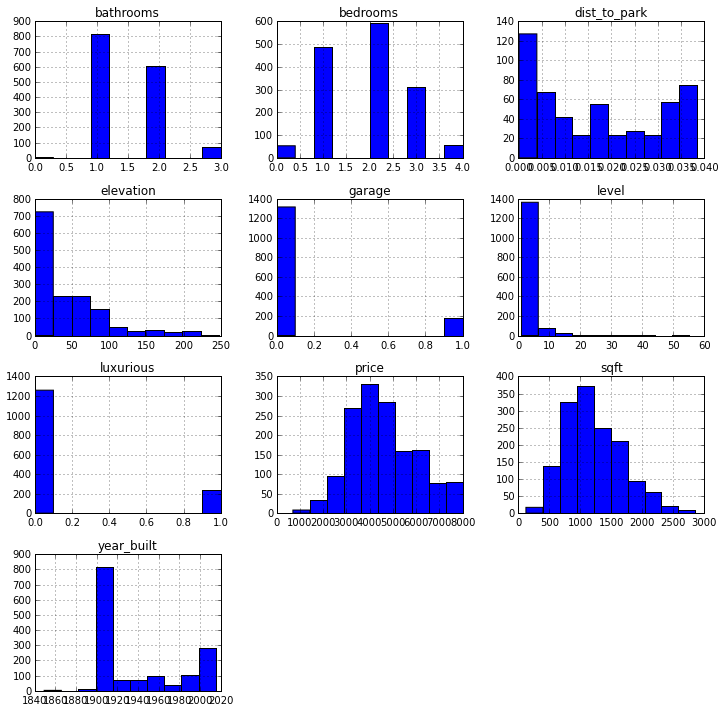

In [99]:
data.hist(column=['bathrooms','bedrooms','price','garage','level','year_built','sqft','elevation','luxurious','dist_to_park'],figsize=(12,12))

In [100]:
class ListTable(list):
    """ Overridden list class which takes a 2-dimensional list of 
        the form [[1,2,3],[4,5,6]], and renders an HTML Table in 
        IPython Notebook. """
    
    def _repr_html_(self):
        html = ["<table>"]
        for row in self:
            html.append("<tr>")
            
            for col in row:
                html.append("<td>{0}</td>".format(col))
            
            html.append("</tr>")
        html.append("</table>")
        return ''.join(html)
    


In [101]:
age = 2015 - data.year_built 
age.name = 'age'
data = pd.concat([data,age],axis=1)

In [102]:
result = sm.ols(formula="price ~ level + bedrooms + bathrooms + garage + age + elevation + dist_to_park +\
neighborhood:sqft:year:luxurious -1", data=data).fit()
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.985
Model:                            OLS   Adj. R-squared:                  0.980
Method:                 Least Squares   F-statistic:                     171.0
Date:                Fri, 04 Dec 2015   Prob (F-statistic):          1.07e-277
Time:                        21:24:26   Log-Likelihood:                -4023.7
No. Observations:                 519   AIC:                             8339.
Df Residuals:                     373   BIC:                             8960.
Df Model:                         146                                         
Covariance Type:            nonrobust                                         
======================================================================================================================================================================
                                                                                                         coef    std err          t      P>|t|      [95.0% Conf. Int.]
----------------------------------------------------------------------------------------------------------------------------------------------------------------------
level                                                                                                 22.8462      5.151      4.435      0.000        12.717    32.976
bedrooms                                                                                             310.5257     88.125      3.524      0.000       137.241   483.811
bathrooms                                                                                            583.3653     95.967      6.079      0.000       394.660   772.070
garage                                                                                               285.4688    188.910      1.511      0.132       -85.993   656.931
age                                                                                                    0.7363      1.420      0.518      0.605        -2.057     3.529
elevation                                                                                             10.5091      2.611      4.025      0.000         5.375    15.643
dist_to_park                                                                                        3.328e+04   5957.572      5.586      0.000      2.16e+04   4.5e+04
neighborhood[Alamo Square]:sqft:year[Period('2011', 'A-DEC')]:luxurious[False]                        -0.6985      0.451     -1.547      0.123        -1.586     0.189
neighborhood[Anza Vista]:sqft:year[Period('2011', 'A-DEC')]:luxurious[False]                        9.238e-09   1.65e-09      5.603      0.000         6e-09  1.25e-08
neighborhood[Bayview]:sqft:year[Period('2011', 'A-DEC')]:luxurious[False]                          -2.834e-08   5.07e-09     -5.591      0.000     -3.83e-08 -1.84e-08
neighborhood[Bayview Heights]:sqft:year[Period('2011', 'A-DEC')]:luxurious[False]                   4.369e-08   7.82e-09      5.588      0.000      2.83e-08  5.91e-08
neighborhood[Bernal Heights]:sqft:year[Period('2011', 'A-DEC')]:luxurious[False]                    1.267e-08   2.27e-09      5.577      0.000       8.2e-09  1.71e-08
neighborhood[Buena Vista Park/Ashbury Heights]:sqft:year[Period('2011', 'A-DEC')]:luxurious[False]  2.205e-08   3.95e-09      5.586      0.000      1.43e-08  2.98e-08
neighborhood[Candlestick Point]:sqft:year[Period('2011', 'A-DEC')]:luxurious[False]                -2.271e-08   4.07e-09     -5.580      0.000     -3.07e-08 -1.47e-08
neighborhood[Central Richmond]:sqft:year[Period('2011', 'A-DEC')]:luxurious[False]                 -5.424e-08   9.71e-09     -5.583      0.000     -7.33e-08 -3.51e-08
neighborhood[Central Sunset]:sqft:year[Period('2011', 'A-DEC')]:luxurious[Fal

In [103]:
output = [['neighborhood','regular','luxurious']]
table = ListTable()
table.append(output[0])

for row in data.neighborhood.unique():
    output_row = [row, '99', '99']
    for i in result.params.index:
        if 'neighborhood' not in i: continue

        if '2015' in i:
            if 'neighborhood[' + row + ']' in i:
                if 'luxurious[True]' in i:
                    output_row[2] = `result.params[i]`
                    output.append(output_row)
                    table.append(output_row)

                if 'luxurious[False]' in i:
                    output_row[1] = `result.params[i]`

table

neighborhood,regular,luxurious
Yerba Buena,1.7833288583632647,3.4161995093703572
Hayes Valley,2.4834799071935492,2.4579381036178436
South Beach,1.8504974880004599,2.3192889948443645
Nob Hill,2.4023962544050188,0.0
Pacific Heights,2.1296673995459443,0.0
Noe Valley,1.7849208958043061,0.0
Potrero Hill,1.8008577383227544,0.0
Visitacion Valley,-0.19690185882752489,0.0
Buena Vista Park/Ashbury Heights,1.1620981184360522,0.0
South of Market,1.926247386054692,2.352082310341892


In [104]:
path = 'rentalnerd_importer/lib/tasks/model_files/'

dtype = [('Effect', 'S100'), ('Coefficient', float)]

with open(path + 'model_features_sf.csv', 'wb') as csvfile:
    modelwriter = csv.writer(csvfile, delimiter=',', quotechar='|', quoting=csv.QUOTE_MINIMAL)

    header = ['Effect','Coefficient']
    table.append(header)
    modelwriter.writerow(header)
    modelwriter.writerow(['base_rent', 0]) # result.params.Intercept])  hardcode 0 as base rent
    modelwriter.writerow(['bedrooms', result.params.bedrooms])
    modelwriter.writerow(['bathrooms', result.params.bathrooms])
    modelwriter.writerow(['dist_to_park', result.params.dist_to_park])
    modelwriter.writerow(['elevation', result.params.elevation])
    modelwriter.writerow(['level', result.params.level])
    modelwriter.writerow(['age', result.params.age])
    modelwriter.writerow(['garage', result.params.garage])
    modelwriter.writerow(['mean square error of residuals', result.mse_resid])

result.cov_params().to_csv(path + 'model_covs_sf.csv')

In [105]:
with open(path + 'model_hoods_sf.csv', 'wb') as csvfile:
    hoodwriter = csv.writer(csvfile, delimiter=',', quotechar='|', quoting=csv.QUOTE_MINIMAL)
    
    for i in output:
        hoodwriter.writerow(i)

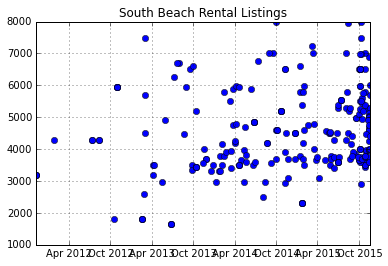

In [106]:
hood = "South Beach"
subdata = data[(data.neighborhood == hood) & (data.date > datetime.date(2011, 5, 1))]
plt.plot_date(x=subdata.date,y=subdata.price)
plt.title(hood + " Rental Listings")
plt.grid(True)

/usr/local/lib/python2.7/site-packages/ipykernel/__main__.py:9: FutureWarning: sort is deprecated, use sort_values(inplace=True) for for INPLACE sorting


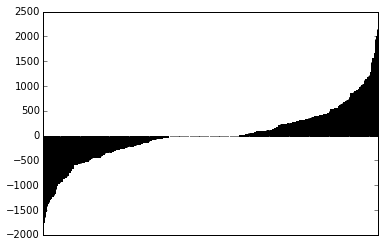

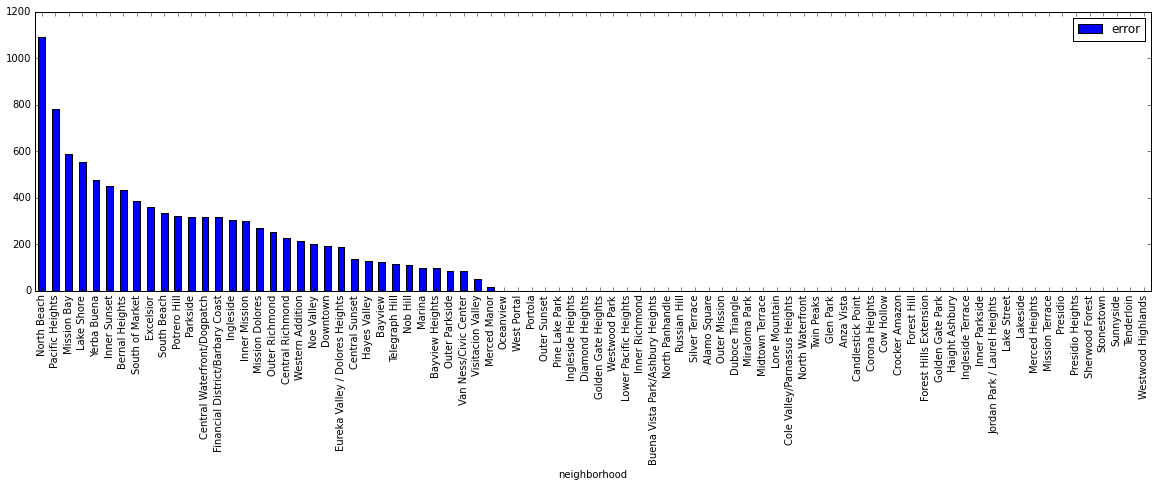

In [107]:
errors = result.resid
errors.name = 'error'
pprice = errors + data.price
pprice.name = "prediction"
data = pd.concat([data, errors], axis=1)
data = pd.concat([data, pprice], axis=1)

# visualize the relationship between the features and the response using scatterplots
errors.sort()
errors.plot(kind='bar').get_xaxis().set_ticks([])

# show errors by neighborhood to see if there are any neighborhoods with funky differences

hooderrors = data[['neighborhood']]

hooderrors = pd.concat([hooderrors,errors.abs()],axis=1)

hood_group = hooderrors.groupby('neighborhood')

import numpy
def median(lst):
    return numpy.median(numpy.array(lst))

error_avg = hood_group.median()
error_avg.sort_values(by='error',ascending=False,inplace=True)
error_avg.plot(kind='bar',figsize=(20,5))


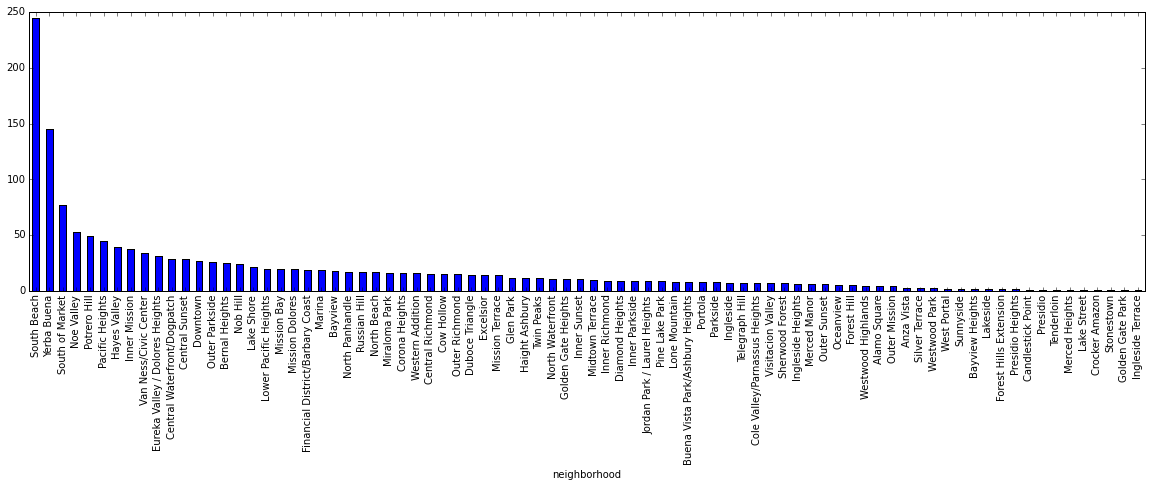

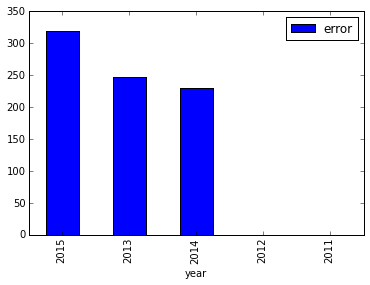

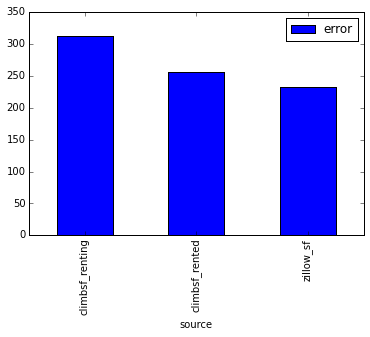

In [108]:
hood_group.size().sort_values(ascending=False).plot(kind='bar',figsize=(20,5))

# show errors by year to see if there are any years with funky differences

yearerrors = data[['year']]

yearerrors = pd.concat([yearerrors,errors.abs()],axis=1)

year_group = yearerrors.groupby('year')
error_avg = year_group.median()
error_avg.sort_values(by='error',ascending=False).plot(kind='bar')

# show errors by source to see if there are any sources have noisy data

srcerrors = data[['source']]

srcerrors = pd.concat([srcerrors,errors.abs()],axis=1)

src_group = srcerrors.groupby('source')
error_avg = src_group.median()
error_avg.sort_values(by='error',ascending=False).plot(kind='bar')

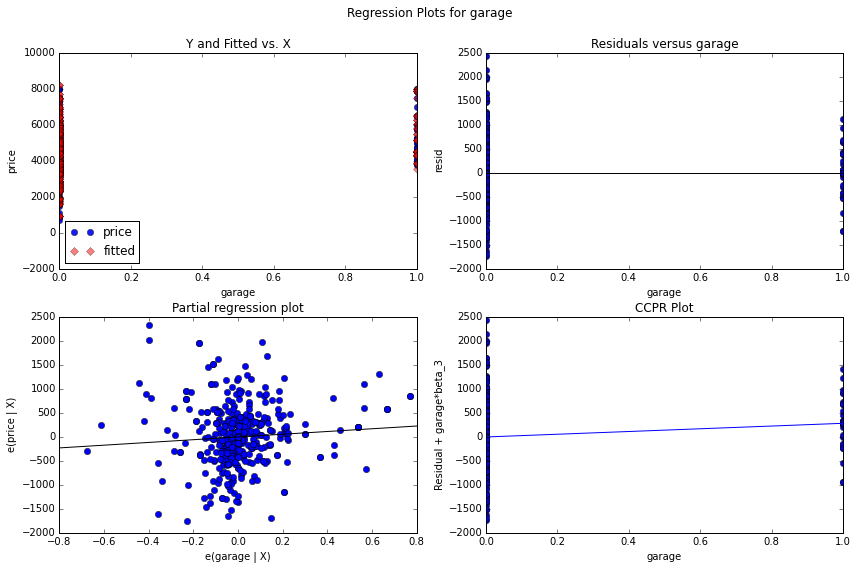

In [109]:
fig = plt.figure(figsize=(12,8))
fig = sma.graphics.plot_regress_exog(result, "garage", fig=fig)

In [110]:
prstd, iv_l, iv_u = wls_prediction_std(result)

zip(data.address, data.price, predictions, prstd, iv_l, iv_u)

[('74 New Montgomery #412',
  3800,
  3800.0000000004402,
  939.79397825489514,
  1952.0414702415858,
  5647.9585297592948),
 ('16 Jessie St #407',
  2000,
  2796.5605781514259,
  715.13958019353015,
  1390.3499428792302,
  4202.7712134236217),
 ('55 Page Street #814',
  3200,
  3199.9999999979605,
  939.79397825489571,
  1352.0414702391049,
  5047.9585297568156),
 ('235 Berry Street #102',
  4300,
  4299.9999999997108,
  939.79397825489548,
  2452.0414702408557,
  6147.9585297585654),
 ('1340 Clay Street #402',
  5975,
  5975.0000000027776,
  939.79397825489605,
  4127.0414702439211,
  7822.9585297616341),
 ('1979 Clay Street',
  5250,
  5108.1570098383236,
  835.63761318809748,
  3465.0057545538984,
  6751.3082651227487),
 ('201 Harrison Street #711',
  2600,
  3538.9405629472076,
  675.6813257304749,
  2210.3184413190324,
  4867.5626845753832),
 ('235 Berry Street #107',
  7500,
  6758.5319905308934,
  718.63367116726738,
  5345.4507693983142,
  8171.6132116634726),
 ('338 Spear Str

In [111]:
# identify the earliest date, number of periods, and number of pairs
base_period = paired.period.min()
num_periods = paired.period.max() - paired.period.min()
print "base period: " + `base_period` + " end period: " + `paired.period.max()` + " and number of periods: " + `num_periods`


base period: Period('2011-01', 'M') end period: Period('2015-11', 'M') and number of periods: 58


number of paired transactions in the data: 491
                                               address  price  period
1392  2200 Pacific Ave APT 2A, San Francisco, CA 94115   7000 2013-08
1396  2200 Pacific Ave APT 2A, San Francisco, CA 94115   8000 2014-06
1601  2200 Pacific Ave APT 2A, San Francisco, CA 94115   7700 2015-10
(297, 57)
(297,)
[    0.     0.     0.     0.     0.     0.     0.     0.     0.     0.
     0.     0.     0.     0.     0.     0.     0.     0.     0.     0.
     0.     0.     0.     0.     0.     0.     0.     0.     0.     0.
     0.     0.     0.     0.     0.     0.     0.     0.     0.     0.
     0.     0.     0.     0.     0.     0.     0.     0.     0.     0.
     0.     0.     0.     0.     0.     0.     0.     0.     0.     0.
     0.     0.     0.     0.     0.     0.     0.     0.     0.     0.
     0.     0.     0.     0.     0.     0.     0.     0.     0.     0.
     0.     0.     0.     0.     0.     0.     0.     0.     0.     0.
     0.     0.   

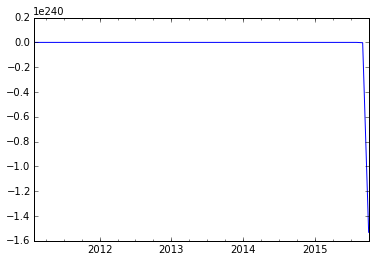

In [138]:
# create year dummy variables (because date isn't very intuitive variable)
data["period"] = pd.DatetimeIndex(data["date"]).to_period('M')

# identify paired transactions
paired = data[['address','price','period']].drop_duplicates().groupby('address')\
.filter(lambda x: len(x) >1)
paired.sort_values(['address','period'],inplace=True)
grouped = paired.groupby('address')
print 'number of paired transactions in the data: ' + `paired.shape[0]`
print grouped.get_group('2200 Pacific Ave APT 2A, San Francisco, CA 94115')

# create a new array to store repeat transactions
num_pairs = paired.shape[0] - grouped.ngroups
X = np.zeros((num_pairs,num_periods-1))
Y = np.zeros(num_pairs)
#Z = X

row_count = 0
# identify houses that rented more than twice, and enter them as separate paired transactions
for name, group in grouped:
    j = len(group.values)
    for i in range(j): #iterate through each repeat transaction
        if i<>0:             # do nothing if first, the next resale is responsible for storing the prior resale in Y
            #print group.values[i][1],group.values[i][2],group.values[i][0] #i[1] is price listed and i[2] is month listed
            X[row_count, group.values[i][2] - base_period - 2] = group.values[i][1] #store this repeat transaction in X matrix
            if group.values[i-1][2] == base_period: #if this is the first transactions, store it in Y 
                Y[row_count] = group.values[i-1][1]
            else:
                X[row_count, group.values[i-1][2] - base_period - 2] = -group.values[i-1][1]
            
            row_count += 1 #update the row counter (note that first transaction doesn't update counter)

print X.shape
print Y.shape
#print Z.shape

print Y
print X[50]

z,resid,rank,sigma = np.linalg.lstsq(X,Y)
print(1/z)
print rank

coeff = 1+1/z
print coeff
linked = coeff
for i in range(1,len(coeff)):
    if abs(z[i]) > 0.5:  # if the growth rate is really high, disregard it
        coeff[i] = 1
    linked[i] = (linked[i-1]) * coeff[i]
    
rng = pd.date_range((base_period+1).to_timestamp(), periods=num_periods-1, freq='M')
index = pd.Series(linked, index=rng)
index.plot()

In [133]:
num_pairs = len(grouped.groups)
print num_pairs

# create the base period matrix Y
Y = np.zeros(num_pairs)

i = 0
for name, group in grouped:
    #print group.period.iloc[0], base_period
    if group.period.iloc[0] == base_period:
        print name + ' rented on ' + `group.period.iloc[0]` + ' for $' + `group.price.iloc[0]`
        Y[i] = group.price.iloc[0]
    i += 1

print Y

194
47 Knollview Way, San Francisco, CA 94131 rented on Period('2011-01', 'M') for $2750
[    0.     0.     0.     0.     0.     0.     0.     0.     0.     0.
     0.     0.     0.     0.     0.     0.     0.     0.     0.     0.
     0.     0.     0.     0.     0.     0.     0.     0.     0.     0.
     0.     0.     0.     0.     0.     0.     0.     0.     0.     0.
     0.     0.     0.     0.     0.     0.     0.     0.     0.     0.
     0.     0.     0.     0.     0.     0.     0.     0.     0.     0.
     0.     0.     0.     0.     0.     0.     0.     0.     0.     0.
     0.     0.     0.     0.     0.     0.     0.     0.     0.     0.
     0.     0.     0.     0.     0.     0.     0.     0.     0.     0.
     0.     0.     0.     0.     0.     0.     0.     0.     0.     0.
     0.     0.     0.     0.     0.     0.     0.     0.     0.     0.
     0.     0.     0.     0.     0.     0.     0.     0.     0.     0.
     0.  2750.     0.     0.     0.     0.     0.     0.   

In [141]:
# create array X with the number of rows equal to number of paired transactions, and number of columns to num periods minus one because base period is in Y already
X = np.zeros((num_pairs,num_periods-1))
#Z = X

i = 0
for name, group in grouped:
    # store the initial purchase price as negative number
    first = group.period.iloc[0]
    if first != base_period:
        #print name + ' rented on ' + `group.period.iloc[0]` + ' for $' + `group.price.iloc[0]`
        X[i,first - base_period - 2] = -group.price.iloc[0]
        #Z[i,first - base_period - 2] = -1
        
    second = group.period.iloc[1]
    X[i,second - base_period - 2] = group.price.iloc[1]
    #Z[i,second - base_period - 2] = 1
    i += 1

print X.shape
print Y.shape
#print Z.shape


z,resid,rank,sigma = np.linalg.lstsq(X,Y)
print(1/z)

(297, 57)
(297,)
[  1.85210094e+03  -1.14805379e-11  -5.66577799e+02   1.47631233e+02
  -1.55325640e-11  -1.89658280e+03   4.38830660e-11   3.14928404e+02
  -1.10867892e+03   8.24365712e-11  -5.33588855e+02  -8.72369696e+04
  -4.18856233e-10   1.87707465e+02  -2.09745582e+02   1.72630208e+02
  -9.32979744e+02  -3.15043945e+02  -2.87675069e+02   1.01778842e+04
  -1.06396437e+03  -5.31311448e+02  -5.82463141e+02  -5.40002979e+01
  -8.18551396e+02  -5.89264829e+02   1.85096873e+02  -4.00670401e+02
  -1.58864811e+03  -9.63391942e+02  -1.91527912e+02   1.62452835e+03
  -6.69479933e+02   1.32647185e+03  -9.26099360e+02   1.64344220e-08
  -3.18285163e-09  -7.13074464e+02  -5.04123077e+03   7.96790274e+02
   2.10346239e+02   1.18349436e+03  -1.99349049e+03  -1.14273758e+02
   1.73068042e+03  -1.86446657e+02  -2.61274446e+02  -5.01662999e+01
   2.19413266e+02   5.96968972e+02  -3.38250323e+03  -6.89399080e+02
   4.48876712e+02  -1.20686893e+01  -1.51266013e+02   2.20659933e+02
  -1.37970526e+02

[  1.85310094e+03   1.00000000e+00  -5.65577799e+02   1.48631233e+02
   1.00000000e+00  -1.89558280e+03   1.00000000e+00   3.15928404e+02
  -1.10767892e+03   1.00000000e+00  -5.32588855e+02  -8.72359696e+04
   1.00000000e+00   1.88707465e+02  -2.08745582e+02   1.73630208e+02
  -9.31979744e+02  -3.14043945e+02  -2.86675069e+02   1.01788842e+04
  -1.06296437e+03  -5.30311448e+02  -5.81463141e+02  -5.30002979e+01
  -8.17551396e+02  -5.88264829e+02   1.86096873e+02  -3.99670401e+02
  -1.58764811e+03  -9.62391942e+02  -1.90527912e+02   1.62552835e+03
  -6.68479933e+02   1.32747185e+03  -9.25099360e+02   1.00000002e+00
   9.99999997e-01  -7.12074464e+02  -5.04023077e+03   7.97790274e+02
   2.11346239e+02   1.18449436e+03  -1.99249049e+03  -1.13273758e+02
   1.73168042e+03  -1.85446657e+02  -2.60274446e+02  -4.91662999e+01
   2.20413266e+02   5.97968972e+02  -3.38150323e+03  -6.88399080e+02
   4.49876712e+02  -1.10686893e+01  -1.50266013e+02   2.21659933e+02
  -1.36970526e+02]


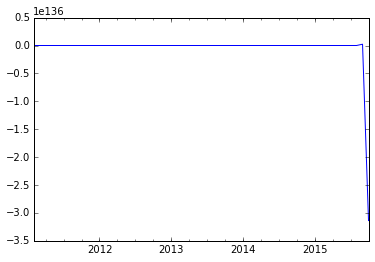

In [140]:
coeff = 1+1/z
print coeff
linked = coeff
for i in range(1,len(coeff)):
    linked[i] = (linked[i-1])*coeff[i]
    
rng = pd.date_range((base_period+1).to_timestamp(), periods=num_periods-1, freq='M')
index = pd.Series(linked, index=rng)
index.plot()

In [116]:
bh = np.dot(np.linalg.inv(np.dot(Z.T,X)),np.dot(Z.T,Y))
print bh

LinAlgError: Singular matrix

In [ ]:
np.linalg.inv(np.dot(Z.T,X))

In [302]:
# Artnet white paper index converted to our dataset

# create year dummy variables (because date isn't very intuitive variable)
data["period"] = pd.DatetimeIndex(data["date"]).to_period('M')

In [332]:
paired = data[['address','price','period']]

# take the log of Prices
log_p = paired.price.apply(np.log)
log_p.name = "log(Price)"
paired = pd.concat([paired,log_p],axis=1)
print len(paired)
paired.head()

1500


,address,price,period,log(Price)
1,74 New Montgomery #412,3800,2011-11,8.242756
2,16 Jessie St #407,2000,2011-12,7.600902
3,55 Page Street #814,3200,2011-12,8.070906
4,235 Berry Street #102,4300,2012-01,8.366370
5,1340 Clay Street #402,5975,2013-02,8.695339


In [333]:
# group data into Sets and calc Y_ist of each item
paired = paired.drop_duplicates().groupby("address").filter(lambda x: len(x) >1)
paired.sort_values(['address','period'],inplace=True)
paired_grp = paired.groupby('address')
print 'number of paired transactions in the data: ' + `paired.shape[0]`
print paired_grp.get_group('2200 Pacific Ave APT 2A, San Francisco, CA 94115')

yist_func = lambda x: x - x.mean()
yist = paired_grp['log(Price)'].transform(yist_func)
yist.name = "Yist"

paired = pd.concat([paired,yist],axis=1)
paired.head()

number of paired transactions in the data: 491
                                               address  price  period  \
1392  2200 Pacific Ave APT 2A, San Francisco, CA 94115   7000 2013-08   
1396  2200 Pacific Ave APT 2A, San Francisco, CA 94115   8000 2014-06   
1601  2200 Pacific Ave APT 2A, San Francisco, CA 94115   7700 2015-10   

      log(Price)  
1392    8.853665  
1396    8.987197  
1601    8.948976  


,address,price,period,log(Price),Yist
2018,"1 Bluxome St, San Francisco, CA 94107",7995,2012-10,8.986572,0.354169
2027,"1 Bluxome St, San Francisco, CA 94107",4700,2015-06,8.455318,-0.177085
1781,"1 Bluxome St, San Francisco, CA 94107",4700,2015-11,8.455318,-0.177085
1481,"1 Daniel Burnham Ct, San Francisco, CA 94109",5000,2014-12,8.517193,0.247446
1482,"1 Daniel Burnham Ct, San Francisco, CA 94109",3500,2015-01,8.160518,-0.109229


In [334]:
# construct regression variables
X = np.column_stack([
    pd.get_dummies(paired.period,prefix="period").iloc[:, 1:], 
    pd.get_dummies(paired.address,prefix="address").iloc[:, :-1]
    ])

X = sma.add_constant(X, prepend=True)

Y = paired.Yist

[-0.37344267 -0.13918019 -0.33115565  0.14750529 -0.19533575  0.19410787
 -0.15931889 -0.19472362  0.01623119  0.14709039 -1.43539942  0.41888954
  0.14889832  0.16886756 -0.28824952  0.32335704 -0.01644762 -0.08238965
  0.04770572 -0.12341631  0.25367059  0.15688625  0.37257377 -0.30940187
  0.1897704   0.25763934  0.23643716  0.34222546  0.22569335  0.38809159
  0.20523538  0.22262406  0.31795424  0.30167185  0.30132182  0.19374828
  0.26439405  0.1595406   0.21170283  0.35533062  0.13820784  0.30900289
  0.6867868   0.44254487  0.30943566  0.32795817  0.53547655  0.25616102
  0.4065345   0.37344267  0.33378555  0.04507575  0.07341835  0.39143835
 -0.02272344  0.07540931 -0.01472254]
[ 100.           87.00712357   71.80933918  115.89394174   82.25584396
  121.42272578   85.27243894   82.30621029  101.63636364  115.84586727
   23.80202745  152.02724228  116.05549766  118.39633288   74.95745314
  138.17585996   98.3686902    92.09130542  104.88619489   88.38956094
  128.87472079  116.9

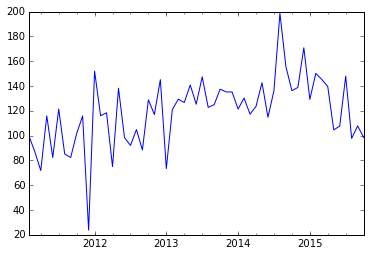

In [335]:
bh = np.dot(np.linalg.inv(np.dot(X.T,X)),np.dot(X.T,Y))

#calculate index
linked = bh[:num_periods-1]
print linked
linked[0] = 100
for i in range(1,len(linked)):
    linked[i] = (np.exp(bh[i]))*100
    
print linked
rng = pd.date_range((base_period+1).to_timestamp(), periods=num_periods-1, freq='M')
index = pd.Series(linked, index=rng)
index.plot()

In [295]:
# replicate Arnet white paper index example using pandas

an = pd.read_csv('artnet.csv')
an.head(6)

,Price,Time,Set
0,2000,0,1
1,5000,1,1
2,5050,1,1
3,6000,1,2
4,3000,2,1
5,4000,2,2


In [296]:
# take the log of Prices
log_p = an.Price.apply(np.log)
log_p.name = "log(Price)"
an = pd.concat([an,log_p],axis=1)
an.head()

,Price,Time,Set,log(Price)
0,2000,0,1,7.600902
1,5000,1,1,8.517193
2,5050,1,1,8.527144
3,6000,1,2,8.699515
4,3000,2,1,8.006368


In [297]:
# group data into Sets and calc Y_ist of each item
an_grp = an.groupby("Set")

yist_func = lambda x: x - x.mean()
yist = an_grp['log(Price)'].transform(yist_func)
yist.name = "Yist"

an = pd.concat([an,yist],axis=1)
an.head()

,Price,Time,Set,log(Price),Yist
0,2000,0,1,7.600902,-0.561999
1,5000,1,1,8.517193,0.354292
2,5050,1,1,8.527144,0.364242
3,6000,1,2,8.699515,0.314821
4,3000,2,1,8.006368,-0.156534


In [298]:
# construct regression variables
X = np.column_stack([
    pd.get_dummies(an.Time,prefix="time").iloc[:, 1:], 
    pd.get_dummies(an.Set,prefix="set").iloc[:, :-1]
    ])

X = sma.add_constant(X, prepend=True)

Y = an.Yist
print X
print Y

[[ 1.  0.  0.  0.  1.  0.]
 [ 1.  1.  0.  0.  1.  0.]
 [ 1.  1.  0.  0.  1.  0.]
 [ 1.  1.  0.  0.  0.  1.]
 [ 1.  0.  1.  0.  1.  0.]
 [ 1.  0.  1.  0.  0.  1.]
 [ 1.  1.  0.  0.  0.  0.]
 [ 1.  0.  0.  1.  0.  0.]
 [ 1.  0.  0.  1.  0.  1.]]
0   -0.561999
1    0.354292
2    0.364242
3    0.314821
4   -0.156534
5   -0.090645
6   -0.030312
7    0.030312
8   -0.224176
Name: Yist, dtype: float64


In [299]:
bh = np.dot(np.linalg.inv(np.dot(X.T,X)),np.dot(X.T,Y))
print bh

#calculate index
linked = bh[:len(bh)-1]
linked[0] = 100
for i in range(1,len(bh)-1):
    linked[i] = (cmath.exp(bh[i]).real)*100
    
print linked

[-0.74161732  0.88122883  0.48553925  0.60200582  0.1796181   0.08535936]
[ 100.          241.38641043  162.50510817  182.57773029  119.67602275]
